### Cab-Driver Agent
            
 - Group Members : Praveen yethapu
                  Jyoti Vishwakarma

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time
# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [3]:
States_track =collections.defaultdict(dict)
sample_Qstate_Qvalues = [((0,0,0),(0,1)),
                          ((0,0,0),(0,2)),
                           ((0,0,0),(0,3)),
                            ((0,0,0),(0,4)),
                            ((0,0,0),(1,0)),
                            ((0,0,0),(1,2)),
                            ((0,0,0),(1,3)),
                            ((0,0,0),(1,4))] 
def initialise_tracking_states():
    for q_values in sample_Qstate_Qvalues:
        States_track[q_values[0]][q_values[1]] = [] 

In [4]:
initialise_tracking_states()
print(sample_Qstate_Qvalues[0][0])
#States_track[(0,5,0)][(0,1)]
States_track

(0, 0, 0)


defaultdict(dict,
            {(0, 0, 0): {(0, 1): [],
              (0, 2): [],
              (0, 3): [],
              (0, 4): [],
              (1, 0): [],
              (1, 2): [],
              (1, 3): [],
              (1, 4): []}})

In [5]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [6]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.85
        self.learning_rate =  0.01      
        self.epsilon = 1
        self.epsilon_max = 1
        #self.epsilon_decay = 0.99995 # For 100000 episodes
        #self.epsilon_decay = 0.9997  # For 25000 episodes
        self.epsilon_decay = 0.9995 # For 10000 episodes
        #self.epsilon_decay = 0.995 # For 1000 episodes
        self.epsilon_min = 0.001
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        # hidden layers
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        
        #Load the model from the existing saved model if exist:
        '''
        from keras.models import load_model
        model_file = './model_weights_dqn'
        import os.path
        if os.path.isfile(model_file):
            print('Loading the weights from h5 file ', model_file)
            model = load_model(model_file)
        '''
        return model


    def get_action(self, state, possible_actions_index):
        """
        get action in a state according to an epsilon-greedy approach
        possible_actions_index, actions are the 'ride requests' that teh driver got.
        """        
        # get action from model using epsilon-greedy policy
        # Decay in ε after each episode       
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from the ride requests
            return random.choice(possible_actions_index)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, self.state_size)

            # Use the model to predict the Q_values.
            q_value = self.model.predict(state)

            # consider only those actions that are part of the possible rides.
            q_vals_possible = []
            for i in possible_actions_index:
                q_vals_possible.append(q_value[0][i])
            return possible_actions_index[np.argmax(q_vals_possible)]
        
    def append_sample(self, state, action, reward, next_state,done):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, done))
    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self,debug=False):
        
        if len(self.memory) > self.batch_size:
            
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            # initialise two matrices - update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)

            # predict the target q-values from states s
            target = self.model.predict(update_input)
            # target for q-network
            target_qval = self.model.predict(update_output)


            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
    def save_tracking_states(self,debug=False):
        # Use the model to predict the q_value of the state we are tacking.
        state_onehot = env.state_encod_arch1([0,0,0])
        state_onehot = np.array(state_onehot).reshape(1, self.state_size)
        q_value = self.model.predict(state_onehot)
        if debug:
            print(q_value)
        for i,each_action in enumerate(States_track[(0,0,0)]):
            if debug:
                print(q_value[0][i])
            States_track[(0,0,0)][each_action].append(q_value[0][i])

    def save(self, name):
        self.model.save(name)
        
    def save_obj(self, obj , name ):
        with open(name + '.pkl', 'wb') as f:
            pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#### Defining the variables required for the Deep Q-network

In [7]:

Episodes = 10000
m = 5 # number of cities, ranges from 1 ..... m
t = 24 # number of hours, ranges from 0 .... t-1
d = 7  # number of days, ranges from 0 ... d-1
total_hrs = 30*24   #  Total no of hours for the Episode

# Invoke Env class
env = CabDriver()

# to store rewards in each episode
rewards_per_episode, episodes = [], []

#Call the DQN agent
agent = DQNAgent(state_size = m+t+d, action_size = len(env.action_space))
max_reward = 0 # Just to check the max reward that is achieved on single Day:

### DQN block

In [8]:
start_time = time.time()

for episode in range(Episodes):

    terminal = False
    episode_reward = 0
    track_reward = False

    # reset at the start of each episode
    #env = CabDriver()
    action_space, state_space, curr_state = env.reset()
    # Save the initial state so that reward can be tracked if initial state is [0,0,0]
    initial_state = env.state_init


    completed_hrs = 0  # Total time driver rode in this episode
    while not terminal:
        # 1. Get the possibl list of the ride requests:
        possible_actions_index, actions = env.requests(curr_state)
        
        # 2. Pick epsilon-greedy action from possible actions for the current state:
        curr_action = agent.get_action(curr_state, possible_actions_index)
        
        # 3. Evaluate reward , next state and the trip time it took:
        next_state, reward, trip_hrs = env.next_state_func(curr_state, action_space[curr_action], Time_matrix)
        
        # 4. Total time driver Completed in this episode
        completed_hrs += trip_hrs
        if (completed_hrs > total_hrs):
            terminal = True

        # 5. Append the experience to the memory:
        agent.append_sample(curr_state, curr_action, reward, next_state, terminal)
        
        # 6. Train the model :
        agent.train_model()
        
        # 7. Keep a track of rewards, Q-values, loss
        episode_reward += reward
        state = next_state
    
    #Checking max_reward: (To check what the max reward that can be achieved using model) :
    if episode_reward > max_reward:
        max_reward = episode_reward
    
    # store total reward obtained in this episode and the save q-values of few states.
    rewards_per_episode.append(episode_reward)
    episodes.append(episode)
    
    agent.save_tracking_states()
    

    # epsilon decay
    if agent.epsilon > agent.epsilon_min:
        agent.epsilon *= agent.epsilon_decay
    
    
    # every 200 episodes:
    if ((episode ) % 200 == 0):
        #agent.save_tracking_states(debug=True)
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}".format(episode,episode_reward,len(agent.memory),agent.epsilon, completed_hrs))
        elapsed_time = time.time() - start_time
        print("Time taken to run %s episodes is : %s" %(str(episode),str(elapsed_time)))
    
    #Every 1000 episodes, save model , reward and state-action q-values:
    if(episode % 1000 == 0):
        print("Saving Model {}".format(episode))
        agent.save(name="model_weights_dqn")
        agent.save_obj(rewards_per_episode,name= "rewards_tracked_cabdriver")
        agent.save_obj(States_track,name= "states_tracked_cabdriver")

    
elapsed_time = time.time() - start_time
print("Saving Model at the END {}".format(episode))
agent.save(name="model_weights_dqn")
agent.save_obj(rewards_per_episode,name= "rewards_tracked_cabdriver")
agent.save_obj(States_track,name= "states_tracked_cabdriver")
print("Time taken to run %s episodes is : %s" %(str(Episodes),str(elapsed_time)))


episode 0, reward -114.0, memory_length 138, epsilon 0.9995 total_time 723
Time taken to run 0 episodes is : 1.4192659854888916
Saving Model 0
episode 200, reward 61.0, memory_length 2000, epsilon 0.9043623824454068 total_time 724
Time taken to run 200 episodes is : 198.3440020084381
episode 400, reward -23.0, memory_length 2000, epsilon 0.8182804590118382 total_time 730
Time taken to run 400 episodes is : 397.396687746048
episode 600, reward 325.0, memory_length 2000, epsilon 0.7403922615512425 total_time 727
Time taken to run 600 episodes is : 538.5548393726349
episode 800, reward 401.0, memory_length 2000, epsilon 0.6699178685348912 total_time 728
Time taken to run 800 episodes is : 681.7753961086273
episode 1000, reward 698.0, memory_length 2000, epsilon 0.606151595428677 total_time 728
Time taken to run 1000 episodes is : 848.0886738300323
Saving Model 1000
episode 1200, reward 929.0, memory_length 2000, epsilon 0.5484549284291772 total_time 725
Time taken to run 1200 episodes is 

In [9]:
print("Maximum Reward that was obtained in a single day is : " , max_reward)

Maximum Reward that was obtained in a single day is :  1933.0


In [10]:
print(rewards_per_episode[-1000::10])

[1511.0, 1359.0, 1174.0, 1443.0, 1471.0, 1295.0, 1434.0, 1474.0, 1394.0, 1527.0, 1498.0, 1439.0, 1664.0, 1518.0, 1491.0, 1583.0, 1514.0, 1745.0, 1561.0, 1532.0, 1660.0, 1470.0, 1537.0, 1709.0, 1677.0, 1461.0, 1692.0, 1466.0, 1375.0, 1543.0, 1573.0, 1343.0, 1511.0, 1387.0, 1692.0, 1582.0, 1388.0, 1505.0, 1385.0, 1525.0, 1534.0, 1592.0, 1596.0, 1521.0, 1668.0, 1723.0, 1391.0, 1465.0, 1538.0, 1275.0, 1416.0, 1497.0, 1508.0, 1632.0, 1574.0, 1538.0, 1608.0, 1536.0, 1570.0, 1602.0, 1299.0, 1337.0, 1506.0, 1453.0, 1597.0, 1596.0, 1443.0, 1634.0, 1303.0, 1672.0, 1577.0, 1601.0, 1737.0, 1413.0, 1624.0, 1579.0, 1465.0, 1528.0, 1487.0, 1585.0, 1518.0, 1604.0, 1543.0, 1488.0, 1601.0, 1316.0, 1492.0, 1493.0, 1496.0, 1734.0, 1367.0, 1447.0, 1586.0, 1437.0, 1482.0, 1536.0, 1672.0, 1588.0, 1471.0, 1784.0]


### Tracking Convergence 
1. Through the reward for each episode
2. Through the state-action q-values

#### 1. Plotting the reward for each episode

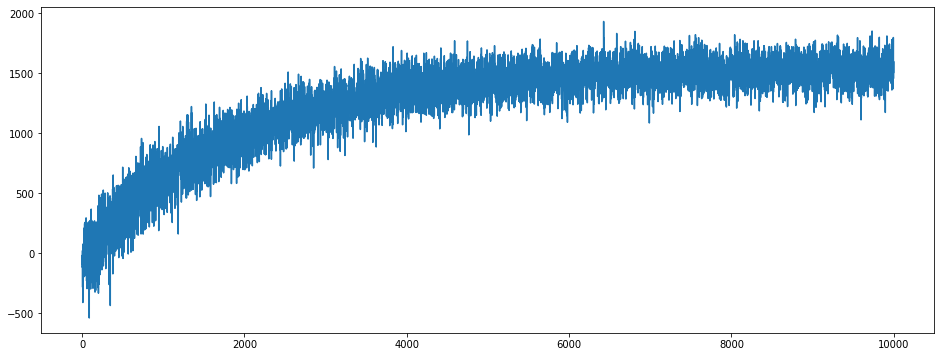

In [11]:
plt.figure(0, figsize=(16,6))
plt.plot(episodes, rewards_per_episode)
plt.show()

#### 2. Plotting q-values for states:

<function matplotlib.pyplot.show(*args, **kw)>

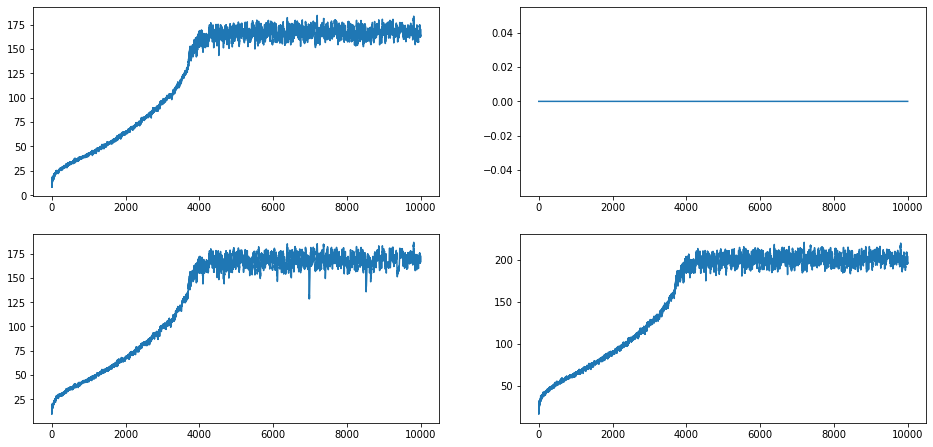

In [12]:
plt.figure(0, figsize=(16,16))
  
x_axis = np.asarray(range(0, len(States_track[(0,0,0)][(1,0)])))
plt.subplot(421)
plt.plot(x_axis,np.asarray(States_track[(0,0,0)][(0,1)]))
plt.show

x_axis = np.asarray(range(0, len(States_track[(0,0,0)][(0,2)])))
plt.subplot(422)
plt.plot(x_axis,np.asarray(States_track[(0,0,0)][(0,2)]))
plt.show

x_axis = np.asarray(range(0, len(States_track[(0,0,0)][(0,3)])))
plt.subplot(423)
plt.plot(x_axis,np.asarray(States_track[(0,0,0)][(0,3)]))
plt.show

x_axis = np.asarray(range(0, len(States_track[(0,0,0)][(0,4)])))
plt.subplot(424)
plt.plot(x_axis,np.asarray(States_track[(0,0,0)][(0,4)]))
plt.show

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [13]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

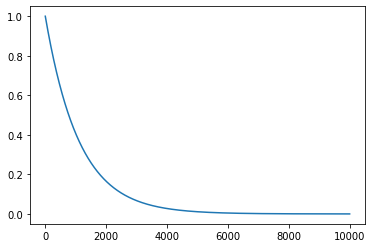

In [14]:
plt.plot(time, epsilon)
plt.show()

### Testing the Agent for single Day:

In [15]:
import time
start_time = time.time()

agent.epsilon=0.001
terminal = False
total_reward = 0
track_reward = False

# reset at the start of each episode
#env = CabDriver()
action_space, state_space, curr_state = env.reset()
# Save the initial state so that reward can be tracked if initial state is [0,0,0]
initial_state = env.state_init
print("Cab Driver started from state : " , curr_state)

completed_hrs = 0  # Total time driver rode in this episode
i = 1 
while not terminal:
    # 1. Get a list of the ride requests driver got.
    possible_actions_index, actions = env.requests(state)
    # 2. Pick epsilon-greedy action from possible actions for the current state.
    curr_action = agent.get_action(state, possible_actions_index)
    print("TRIP%s  -->Current state is  %s and action taken is : %s" %(str(i),str(curr_state),str(action_space[curr_action])))
    # 3. Evaluate your reward and next state
    #reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
    next_state, reward, trip_hrs = env.next_state_func(curr_state, action_space[curr_action], Time_matrix)
    

    # 4. Total time driver rode in this episode
    completed_hrs += trip_hrs
    if (completed_hrs > total_hrs):
        terminal = True

    # 5. Append the experience to the memory
    agent.append_sample(curr_state, curr_action, reward, next_state, terminal)

    # 6. Train the model by calling function agent.train_model
    agent.train_model()

    # 7. Keep a track of rewards, Q-values, loss
    total_reward += reward
    print("       -->Reward for this Trip is : %s and total reward accumulated is : %s " %(str(reward),str(total_reward)))
    state = next_state
    i += 1


Cab Driver started from state :  [2, 1, 0]
TRIP1  -->Current state is  [2, 1, 0] and action taken is : [0, 2]
       -->Reward for this Trip is : -2.0 and total reward accumulated is : -2.0 
TRIP2  -->Current state is  [2, 1, 0] and action taken is : [0, 3]
       -->Reward for this Trip is : 30.0 and total reward accumulated is : 28.0 
TRIP3  -->Current state is  [2, 1, 0] and action taken is : [0, 3]
       -->Reward for this Trip is : 30.0 and total reward accumulated is : 58.0 
TRIP4  -->Current state is  [2, 1, 0] and action taken is : [2, 1]
       -->Reward for this Trip is : 20.0 and total reward accumulated is : 78.0 
TRIP5  -->Current state is  [2, 1, 0] and action taken is : [0, 3]
       -->Reward for this Trip is : 30.0 and total reward accumulated is : 108.0 
TRIP6  -->Current state is  [2, 1, 0] and action taken is : [2, 3]
       -->Reward for this Trip is : 24.0 and total reward accumulated is : 132.0 
TRIP7  -->Current state is  [2, 1, 0] and action taken is : [0, 3]


       -->Reward for this Trip is : -2.0 and total reward accumulated is : 1405.0 
TRIP60  -->Current state is  [2, 1, 0] and action taken is : [2, 3]
       -->Reward for this Trip is : 24.0 and total reward accumulated is : 1429.0 
TRIP61  -->Current state is  [2, 1, 0] and action taken is : [0, 3]
       -->Reward for this Trip is : 30.0 and total reward accumulated is : 1459.0 
TRIP62  -->Current state is  [2, 1, 0] and action taken is : [2, 3]
       -->Reward for this Trip is : 24.0 and total reward accumulated is : 1483.0 
TRIP63  -->Current state is  [2, 1, 0] and action taken is : [2, 1]
       -->Reward for this Trip is : 20.0 and total reward accumulated is : 1503.0 
TRIP64  -->Current state is  [2, 1, 0] and action taken is : [0, 3]
       -->Reward for this Trip is : 30.0 and total reward accumulated is : 1533.0 
TRIP65  -->Current state is  [2, 1, 0] and action taken is : [0, 3]
       -->Reward for this Trip is : 30.0 and total reward accumulated is : 1563.0 
TRIP66  -->

In [16]:
print("***************************************")
print("Total reward for the Day is : " , total_reward)
print("Average reward for each Trip in a day is : " , total_reward/i)
print("***************************************")

***************************************
Total reward for the Day is :  1882.0
Average reward for each Trip in a day is :  22.951219512195124
***************************************


### Testing the States tracked from pkl file

In [17]:
import os
if os.path.isfile('states_tracked_cabdriver.pkl'):
    print("File exist")
    with open('states_tracked_cabdriver.pkl', 'rb') as handle:
        States_track_test = pickle.load(handle)

File exist


<function matplotlib.pyplot.show(*args, **kw)>

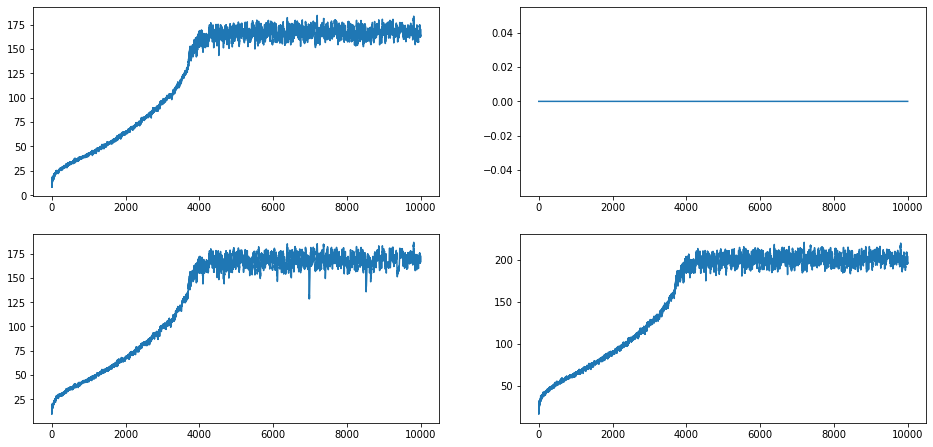

In [18]:
plt.figure(0, figsize=(16,16))
  
x_axis = np.asarray(range(0, len(States_track_test[(0,0,0)][(0,1)])))
plt.subplot(421)
plt.plot(x_axis,np.asarray(States_track_test[(0,0,0)][(0,1)]))
plt.show

x_axis = np.asarray(range(0, len(States_track_test[(0,0,0)][(0,2)])))
plt.subplot(422)
plt.plot(x_axis,np.asarray(States_track_test[(0,0,0)][(0,2)]))
plt.show

x_axis = np.asarray(range(0, len(States_track_test[(0,0,0)][(0,3)])))
plt.subplot(423)
plt.plot(x_axis,np.asarray(States_track_test[(0,0,0)][(0,3)]))
plt.show

x_axis = np.asarray(range(0, len(States_track_test[(0,0,0)][(0,4)])))
plt.subplot(424)
plt.plot(x_axis,np.asarray(States_track_test[(0,0,0)][(0,4)]))
plt.show

In [19]:
agent.save_tracking_states(env,debug=True)

TypeError: save_tracking_states() got multiple values for argument 'debug'